This dataset shows the NYC taxi demand from 2014–07–01 to 2015–01–31 with an observation every half hour. In this period 5 anomalies are present, in term of deviation from a normal behavior. They occur respectively during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.
goal is to detect the anomalies in the best way possible.

In [38]:
import tensorflow as tf

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import math
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", tf.keras.__version__)
print("Tensorflow: ", tf.__version__)


Python:  3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
pandas:  0.25.1
numpy:  1.17.2
seaborn:  0.9.0
matplotlib:  3.1.1
sklearn:  0.21.3
Keras:  2.2.4-tf
Tensorflow:  2.0.0-rc1


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6030070141730997907
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6614766059
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14698214283844230400
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [4]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.set(rc={'axes.facecolor':'lightgray', 'figure.facecolor':'lightgray'})
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [5]:

tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']




In [6]:
i = 7

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)

tensorlog:  nyc_taxi
dataFilePath:  data/nyc_taxi.csv


In [8]:
df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
df['Datetime'] = pd.to_datetime(df['timestamp'])
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['hour'] = df['Datetime'].dt.hour
#df['hour'] = [1 if (ele >= 8 and ele < 20) else 0 for ele in df["hour"]]


df = df[(df.Datetime > '2014-09-01') & (df.Datetime < '2014-11-30')]
df = df.reset_index(drop=True)
print(df.shape)
print(df.head(5))
training_points = 2800


Shape: 10320
Head:
(4319, 6)
             timestamp  value            Datetime  dayofweek  month  hour
0  2014-09-01 00:30:00  12908 2014-09-01 00:30:00          0      9     0
1  2014-09-01 01:00:00  10842 2014-09-01 01:00:00          0      9     1
2  2014-09-01 01:30:00   9248 2014-09-01 01:30:00          0      9     1
3  2014-09-01 02:00:00   8588 2014-09-01 02:00:00          0      9     2
4  2014-09-01 02:30:00   7631 2014-09-01 02:30:00          0      9     2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4319 entries, 0 to 4318
Data columns (total 6 columns):
timestamp    4319 non-null object
value        4319 non-null int64
Datetime     4319 non-null datetime64[ns]
dayofweek    4319 non-null int64
month        4319 non-null int64
hour         4319 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 202.6+ KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
value,4319.0,15765.366752,7081.491478,1431.0,11374.5,17459.0,20459.5,39197.0
dayofweek,4319.0,2.967354,1.985729,0.0,1.0,3.0,5.0,6.0
month,4319.0,9.989118,0.809635,9.0,9.0,10.0,11.0,11.0
hour,4319.0,11.502663,6.921577,0.0,6.0,12.0,17.5,23.0


In [11]:
df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
timestamp,4319,4319,2014-10-04 09:00:00,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
value,4319,NaN,NaT,NaN,NaT,NaT,15765.4,7081.49,1431,11374.5,17459,20459.5,39197
Datetime,4319,4319,2014-11-12 04:30:00,1,2014-09-01 00:30:00,2014-11-29 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dayofweek,4319,NaN,NaT,NaN,NaT,NaT,2.96735,1.98573,0,1,3,5,6
month,4319,NaN,NaT,NaN,NaT,NaT,9.98912,0.809635,9,9,10,11,11
hour,4319,NaN,NaT,NaN,NaT,NaT,11.5027,6.92158,0,6,12,17.5,23


In [12]:
df.value.quantile([.25, .5])

0.25    11374.5
0.50    17459.0
Name: value, dtype: float64

Text(0.5, 1.0, 'Time Series of value by date time')

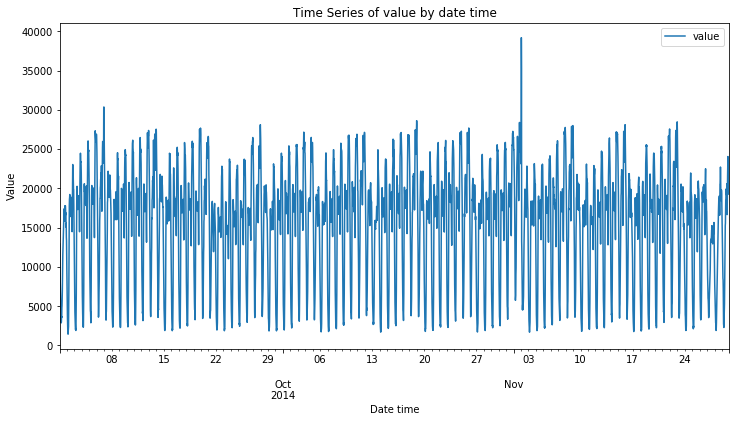

In [13]:
df.shape
df.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

Text(0, 0.5, 'correlation coeff')

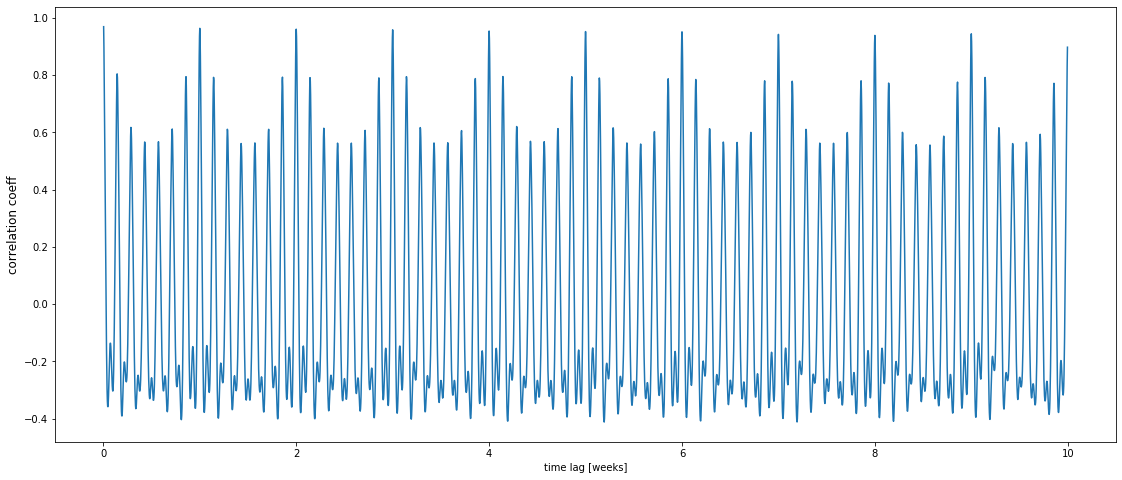

In [14]:
timeLags = np.arange(1,10*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]
plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr)
plt.xlabel('time lag [weeks]')
plt.ylabel('correlation coeff', fontsize=12)

Text(0.5, 1.0, 'Time Series of value by date time')

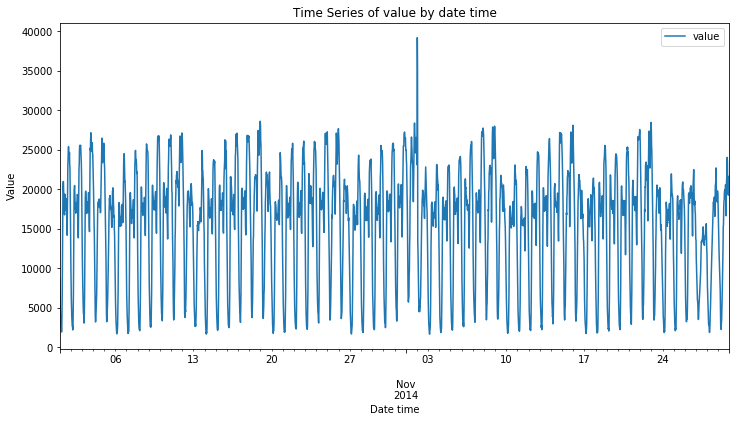

In [15]:
df2 = df[(df.Datetime > '2014-10-01') & (df.Datetime < '2015-01-30')]
df2.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [16]:
df.value.describe()

count     4319.000000
mean     15765.366752
std       7081.491478
min       1431.000000
25%      11374.500000
50%      17459.000000
75%      20459.500000
max      39197.000000
Name: value, dtype: float64

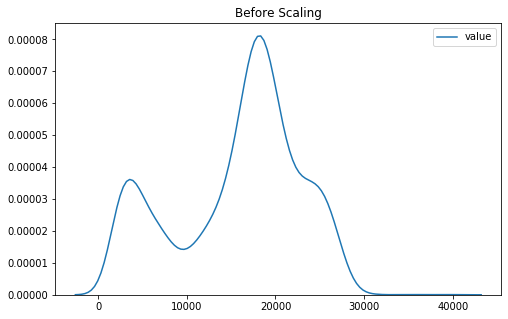

In [17]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])),columns=['value'])
print('Shape:' , df.shape[0])

df.head(5)

Shape: 4319


,timestamp,value,Datetime,dayofweek,month,hour,scaled_value
0,2014-09-01 00:30:00,12908,2014-09-01 00:30:00,0,9,0,0.303898
1,2014-09-01 01:00:00,10842,2014-09-01 01:00:00,0,9,1,0.249192
2,2014-09-01 01:30:00,9248,2014-09-01 01:30:00,0,9,1,0.206985
3,2014-09-01 02:00:00,8588,2014-09-01 02:00:00,0,9,2,0.189509
4,2014-09-01 02:30:00,7631,2014-09-01 02:30:00,0,9,2,0.164169


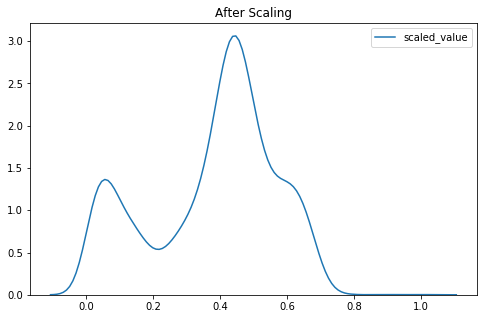

In [19]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

In [20]:
df.head(5)

,timestamp,value,Datetime,dayofweek,month,hour,scaled_value
0,2014-09-01 00:30:00,12908,2014-09-01 00:30:00,0,9,0,0.303898
1,2014-09-01 01:00:00,10842,2014-09-01 01:00:00,0,9,1,0.249192
2,2014-09-01 01:30:00,9248,2014-09-01 01:30:00,0,9,1,0.206985
3,2014-09-01 02:00:00,8588,2014-09-01 02:00:00,0,9,2,0.189509
4,2014-09-01 02:30:00,7631,2014-09-01 02:30:00,0,9,2,0.164169


In [21]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps = 64
n_features =4
n_steps_out =1
# split into samples
rawsequence = np.array(df[['scaled_value', 'dayofweek', 'month', 'hour']].values)
#rawsequence = np.array(df['scaled_value'])
trainsequence = rawsequence[0:training_points]
testsequence = rawsequence[training_points:]

X_train, y_train = split_sequence(trainsequence, n_steps, n_steps_out)
X_test, y_test = split_sequence(testsequence, n_steps, n_steps_out)
# summarize the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#print(rawsequence[0:12])
for i in range(2):
	print(X_train[i][0:4], y_train[i])

(2736, 64, 4) (2736, 1, 4)
(1455, 64, 4) (1455, 1, 4)
[[0.30389769 0.         9.         0.        ]
 [0.2491924  0.         9.         1.        ]
 [0.20698512 0.         9.         1.        ]
 [0.18950908 0.         9.         2.        ]] [[0.46028173 1.         9.         8.        ]]
[[0.2491924  0.         9.         1.        ]
 [0.20698512 0.         9.         1.        ]
 [0.18950908 0.         9.         2.        ]
 [0.16416883 0.         9.         2.        ]] [[0.47105862 1.         9.         9.        ]]


In [22]:
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)

(2736, 64, 4)
(2736, 64, 4)


In [23]:
print(y_train.shape)
y_train = y_train.reshape(y_train.shape[0],n_features)
print(y_train.shape)

(2736, 1, 4)
(2736, 4)


In [27]:
inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
#dense = Dense(50)(lstm)
out = tf.keras.layers.Dense(4)(lstm)

model = tf.keras.Model(inputs, out)

model.compile(loss='mse', metrics=['mse', 'accuracy', 'binary_accuracy'], 
              optimizer='adam')
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 4)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64, 128)           35328     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 54,020
Trainable params: 54,020
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
#model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, n_features), return_sequences=False))
#model.add(Dense(4, activation='relu'))


In [29]:
from os.path import expanduser
home = expanduser("~")
home

'C:\\Users\\sridh'

In [31]:
logfilename = "lstm1"
batch_size=32
epochs=10

model.fit(x=X_train, y=y_train,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, 
                       callbacks=[tf.keras.callbacks.TensorBoard(log_dir='{0}\logs\{1}'.format(home, logfilename))])

Train on 2736 samples
Epoch 1/10
2736/2736 [==============================] - 12s 5ms/sample - loss: 35.8148 - mse: 35.8148 - accuracy: 0.5625 - binary_accuracy: 0.0477
Epoch 2/10
2736/2736 [==============================] - 3s 1ms/sample - loss: 16.5028 - mse: 16.5028 - accuracy: 0.5629 - binary_accuracy: 0.0483
Epoch 3/10
2736/2736 [==============================] - 3s 1ms/sample - loss: 11.9078 - mse: 11.9078 - accuracy: 0.6528 - binary_accuracy: 0.0483
Epoch 4/10
2736/2736 [==============================] - 3s 1ms/sample - loss: 8.4747 - mse: 8.4747 - accuracy: 0.9156 - binary_accuracy: 0.0483
Epoch 5/10
2736/2736 [==============================] - 3s 1ms/sample - loss: 6.8755 - mse: 6.8755 - accuracy: 0.8999 - binary_accuracy: 0.0483
Epoch 6/10
2736/2736 [==============================] - 3s 1ms/sample - loss: 4.6898 - mse: 4.6898 - accuracy: 0.9313 - binary_accuracy: 0.0483
Epoch 7/10
2736/2736 [==============================] - 3s 1ms/sample - loss: 4.0983 - mse: 4.0983 - accura

In [32]:
test1 = testsequence[:n_steps]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
print(test1.shape)
test1_pred = model.predict(x=test1)
print(testsequence[n_steps-2:n_steps+2])
print(test1_pred)

test1 = testsequence[128:n_steps+128]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
test1_pred = model.predict(x=test1)
print(testsequence[128+n_steps-2:128+n_steps+2])
print(test1_pred)

(64, 4)
(1, 64, 4)
[[ 0.40560292  3.         10.         15.        ]
 [ 0.3488058   3.         10.         16.        ]
 [ 0.31605147  3.         10.         16.        ]
 [ 0.39588519  3.         10.         17.        ]]
[[ 0.64926994  3.6361103   9.425899   18.424473  ]]
(64, 4)
[[ 0.12174972  6.         11.          7.        ]
 [ 0.12839591  6.         11.          8.        ]
 [ 0.19435471  6.         11.          8.        ]
 [ 0.23089551  6.         11.          9.        ]]
[[0.2685038 4.7827783 9.651809  8.068667 ]]


In [33]:
y_pred = model.predict(x=X_test)
y_pred

array([[ 0.62588876,  2.0300777 ,  9.6989565 , 15.728035  ],
       [ 0.5524377 ,  1.7010788 ,  9.297403  , 17.749063  ],
       [ 0.6182565 ,  2.983157  ,  9.498411  , 18.260025  ],
       ...,
       [ 0.6259244 ,  3.7271984 ,  9.81279   , 17.977015  ],
       [ 0.43414608,  3.0257356 ,  9.885285  , 15.637981  ],
       [ 0.4213042 ,  3.090059  ,  9.941201  , 14.442216  ]],
      dtype=float32)

In [34]:
y_test.shape = (y_test.shape[0], n_features)
y_test.shape

(1455, 4)

In [39]:

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1.776


In [40]:

#testing_dataset = sequence
print("testing_dataset: ", y_test.shape)
print("testing_pred: ", y_pred.shape)

print(y_test[128:130:])
print(y_pred[128:130])
errors = y_test - y_pred
print(errors.shape)

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

testing_dataset:  (1455, 4)
testing_pred:  (1455, 4)
[[ 0.19435471  6.         11.          8.        ]
 [ 0.23089551  6.         11.          9.        ]]
[[0.15914255 4.6329746  9.4952545  7.4716277 ]
 [0.33840075 4.9944882  9.670002   9.460393  ]]
(1455, 4)
Test RMSE: 1.776


RangeIndex(start=2800, stop=4319, step=1)
(1455, 4)
       eval
0  0.309837
1  0.156553
2  0.129775
3  0.109879
4  0.024896
RangeIndex(start=0, stop=1455, step=1)
                Datetime  scaled_value  dayofweek  month  hour
2800 2014-10-29 08:30:00      0.483927          2     10     8
2801 2014-10-29 09:00:00      0.462877          2     10     9
2802 2014-10-29 09:30:00      0.444103          2     10     9
2803 2014-10-29 10:00:00      0.398798          2     10    10
2804 2014-10-29 10:30:00      0.407933          2     10    10
(1519, 5)
(1519, 6)
             Datetime  scaled_value  dayofweek  month  hour      eval
0 2014-10-29 08:30:00      0.483927          2     10     8  0.309837
1 2014-10-29 09:00:00      0.462877          2     10     9  0.156553
2 2014-10-29 09:30:00      0.444103          2     10     9  0.129775
3 2014-10-29 10:00:00      0.398798          2     10    10  0.109879
4 2014-10-29 10:30:00      0.407933          2     10    10  0.024896
             Dateti

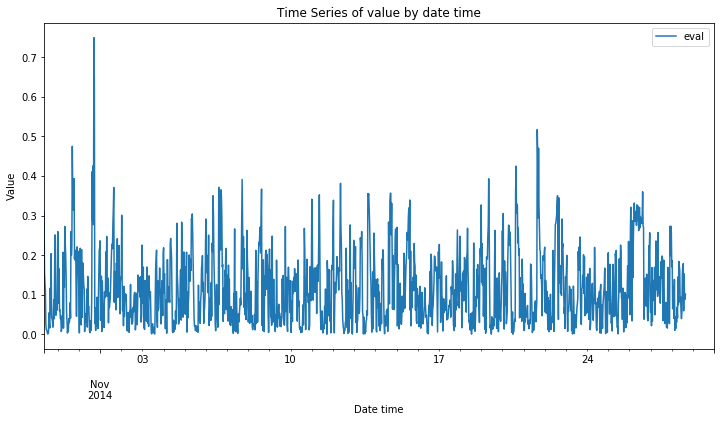

In [41]:
df2 = df.copy()
df2 = df2.loc[training_points:]
df2 = df2[['Datetime', 'scaled_value', "dayofweek", "month", "hour"]]
print(df2.index)

errorsDF = pd.DataFrame(errors, columns=['eval','edow','emonth','ehour'])
#errorsDF = pd.DataFrame(errors, columns=['a'])
print(errorsDF.shape)
errorsDF = errorsDF[['eval']]
errorsDF['eval'] = errorsDF['eval'].abs()
#errorsDF['predval']=scaler.inverse_transform(pd.DataFrame(errorsDF['predval']))
print(errorsDF.head(5))
print(errorsDF.index)

print(df2.head(5))
print(df2.shape)

df2.reset_index(drop=True, inplace=True)
errorsDF.reset_index(drop=True, inplace=True)

dfModified = pd.concat([df2, errorsDF], axis=1)
print(dfModified.shape)
print(dfModified.head(5))
dfModified.plot(x='Datetime', y='eval', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

df2 = dfModified[(dfModified.Datetime >= '2014-11-02') & (dfModified.Datetime < '2014-11-03')]
df2 = df2.reset_index(drop=True)
print(df2.head(5))

In [42]:
y_testDF = pd.DataFrame(y_test, columns=['val','origdow','origmonth','orighour'])
y_predDF = pd.DataFrame(y_pred, columns=['val','preddow','predmonth','predhour'])
y_testDF = y_testDF[['val']]
y_predDF = y_predDF[['val']]
#y_testDF['origval']=scaler.inverse_transform(pd.DataFrame(y_testDF['origval']))
#y_predDF['predval']=scaler.inverse_transform(pd.DataFrame(y_predDF['predval']))
print(y_testDF.head(5))
print(y_predDF.head(5))

        val
0  0.316051
1  0.395885
2  0.488482
3  0.537626
4  0.592358
        val
0  0.625889
1  0.552438
2  0.618257
3  0.647506
4  0.617254


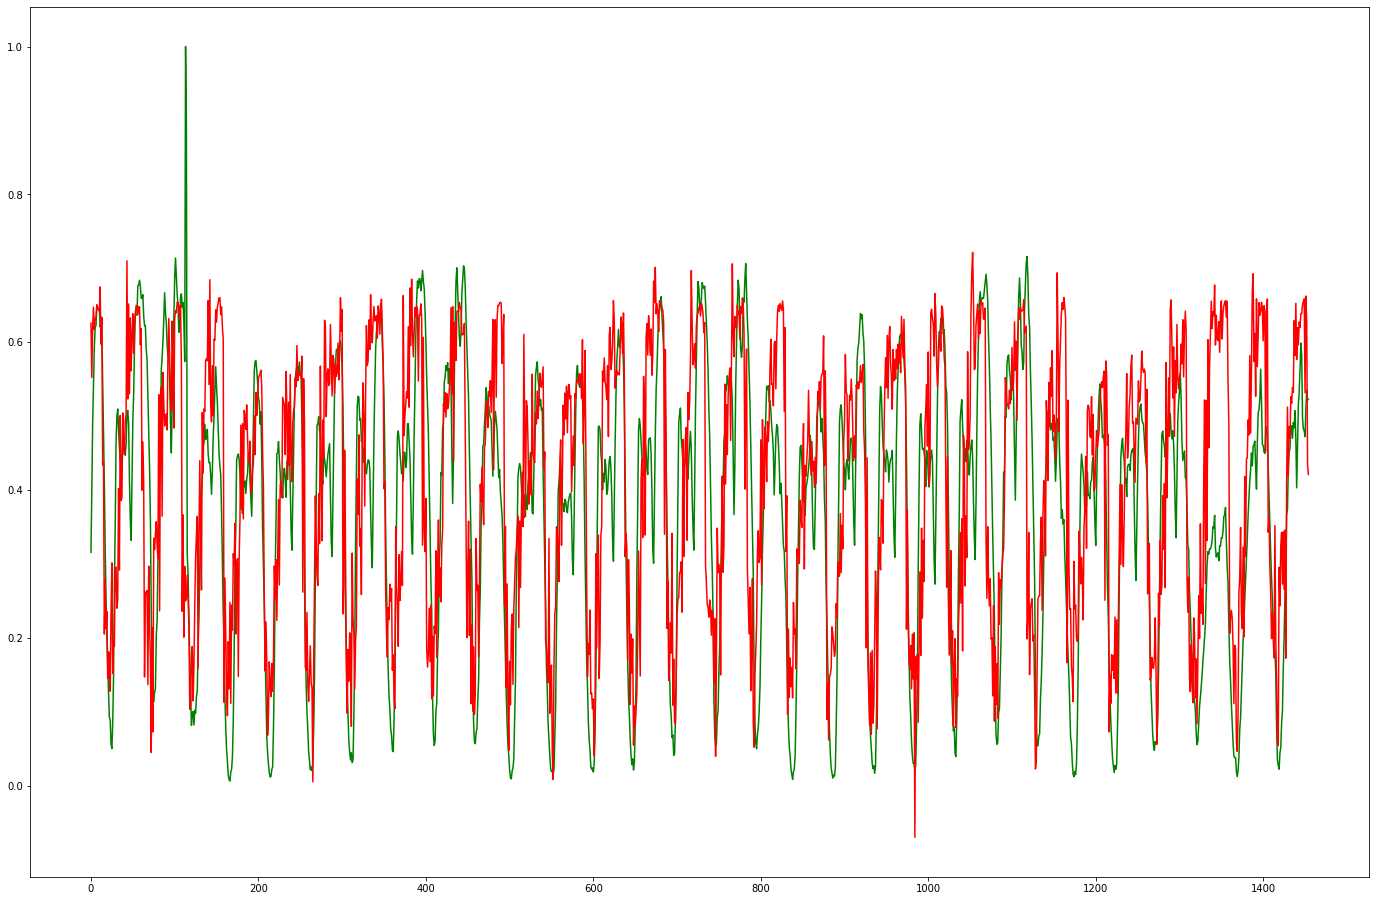

In [43]:
plt.figure(figsize=(24,16))
plt.plot(y_testDF, color='green')
plt.plot(y_predDF, color='red')

In [44]:
#based on cutoff after sorting errors
dist = np.linalg.norm(y_testDF - y_predDF, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.995 * len(scores))
print(cutoff)
print(scores[cutoff:])
threshold= scores[cutoff]


(1455,)
1447
[0.42494956 0.42576317 0.45830777 0.47025759 0.47509911 0.51720834
 0.64009768 0.74971756]


In [45]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=np.zeros(df.shape[0])
error = np.zeros(df.shape[0])
i=training_points+n_steps
print(i)
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label[i] = 1
    error[i] = dist
    i = i + 1
print(len(y_label))
print(len(error))

2864
4319
4319


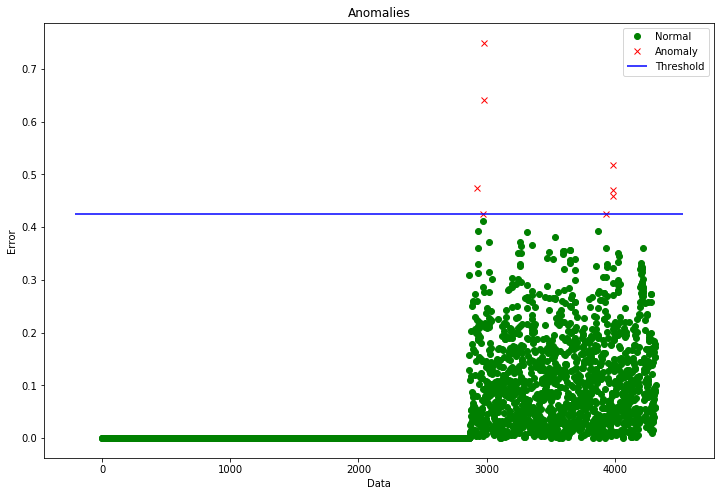

In [46]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

In [47]:
print(df.shape)
print(len(y_label))
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['scaled_value'],
                    'error': error, 'anomaly': y_label})
adf.head(5)


(4319, 7)
4319


,Datetime,observation,error,anomaly
0,2014-09-01 00:30:00,0.303898,0.0,0.0
1,2014-09-01 01:00:00,0.249192,0.0,0.0
2,2014-09-01 01:30:00,0.206985,0.0,0.0
3,2014-09-01 02:00:00,0.189509,0.0,0.0
4,2014-09-01 02:30:00,0.164169,0.0,0.0


Text(0.5, 1.0, 'Time Series of value by date time')

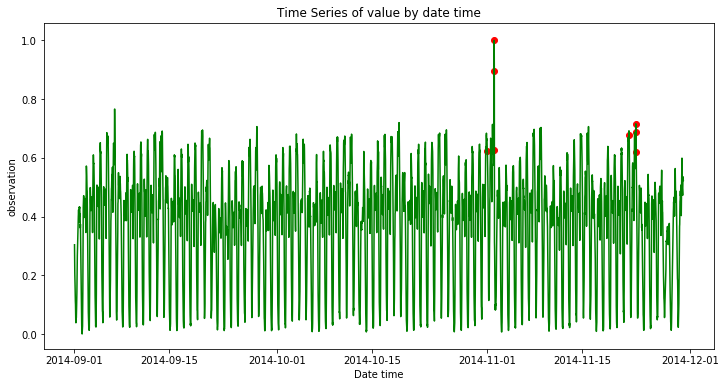

In [48]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')